In [ ]:
# 1. Cài đặt thư viện
!pip install -q transformers datasets scikit-learn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.1 MB/s eta 0:00:00


In [ ]:
# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 3. Load dữ liệu từ file train/val/test
import json
from datasets import Dataset

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return Dataset.from_list(data)

train_path = "/content/drive/MyDrive/KTDL/train.json"
val_path   = "/content/drive/MyDrive/KTDL/val.json"
test_path  = "/content/drive/MyDrive/KTDL/test.json"

train_dataset = load_data(train_path)
val_dataset = load_data(val_path)
test_dataset = load_data(test_path)

In [ ]:
# In kích thước và dòng đầu tiên của từng tập
print("Train dataset:", len(train_dataset))
print(train_dataset[0])

print("\nValidation dataset:", len(val_dataset))
print(val_dataset[0])

print("\nTest dataset:", len(test_dataset))
print(test_dataset[0])

Train dataset: 9665
{'claim': 'Sự mất tập trung của Michael Jordan trong trận chung kết NBA 1997 đã khiến Chicago Bulls suýt thua Utah Jazz, dù đang dẫn trước ở hiệp cuối.', 'evidence': 'Michael Jordan đã ghi 38 điểm, bao gồm cú ném quyết định, trong "The Flu Game" ở Game 5 của NBA Finals 1997, giúp Chicago Bulls giành chiến thắng trước Utah Jazz dù anh bị sốt, cho thấy sự tập trung cao độ.', 'label': 'REFUTES'}

Validation dataset: 1208
{'claim': 'Rác thải nhựa có thể gây nghẽn các tuyến đường thủy và hệ thống thoát nước thành phố.', 'evidence': 'Rác nhựa như túi nilon, chai nhựa thường gây tắc nghẽn các cống thoát nước, dẫn đến ngập úng và ô nhiễm nước trong nhiều thành phố trên thế giới.', 'label': 'SUPPORTS'}

Test dataset: 1209
{'claim': 'Phương pháp thống kê mô tả không thể phát hiện được mối quan hệ giữa các biến số trong bộ dữ liệu.', 'evidence': 'Thống kê mô tả giúp tổng hợp và trình bày dữ liệu, trong khi mối quan hệ giữa các biến số thường được phân tích qua các kỹ thuật như

In [ ]:
# 4. Tiền xử lý
from transformers import AutoTokenizer

model_checkpoint = "FPTAI/vibert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess(example):
    return tokenizer(
        example["claim"], example["evidence"],
        truncation=True, padding="max_length", max_length=256
    )

train_tokenized = train_dataset.map(preprocess, batched=True)
val_tokenized   = val_dataset.map(preprocess, batched=True)
test_tokenized  = test_dataset.map(preprocess, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

Map:   0%|          | 0/9665 [00:00<?, ? examples/s]

Map:   0%|          | 0/1208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

In [ ]:
# 5. Mã hóa label
label2id = {"SUPPORTS": 0, "REFUTES": 1}
id2label = {0: "SUPPORTS", 1: "REFUTES"}

def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

train_tokenized = train_tokenized.map(encode_labels)
val_tokenized   = val_tokenized.map(encode_labels)
test_tokenized  = test_tokenized.map(encode_labels)

Map:   0%|          | 0/9665 [00:00<?, ? examples/s]

Map:   0%|          | 0/1208 [00:00<?, ? examples/s]

Map:   0%|          | 0/1209 [00:00<?, ? examples/s]

In [ ]:
# 6. Tạo mô hình
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FPTAI/vibert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 7. Huấn luyện
from transformers import TrainingArguments, Trainer, EvalPrediction
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def compute_metrics(pred: EvalPrediction):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "Accuracy": accuracy_score(labels, preds),
        "F1-score": f1_score(labels, preds, average="macro"),
        "Precision": precision_score(labels, preds, average="macro"),
        "Recall": recall_score(labels, preds, average="macro")
    }

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/KTDL/vibert",
    report_to="none",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    warmup_ratio=0.1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="F1-score"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-9-c6655ec5df55>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Huấn luyện
print("Training...")
trainer.train()
trainer.save_model("/content/drive/MyDrive/KTDL/vibert")

# 8. Đánh giá sau huấn luyện
print("\n Kết quả đánh giá trên tập validation:")
metrics_val_1 = trainer.evaluate(val_tokenized)
for k, v in metrics_val_1.items():
    if k != 'eval_loss':
        print(f"{k}: {v:.4f}")

print("\n Kết quả đánh giá trên tập test:")
preds = trainer.predict(test_tokenized)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Precision,Recall
1,0.557300,0.408993,0.841887,0.837833,0.845707,0.834537
2,0.373700,0.506833,0.826159,0.825949,0.828685,0.832053
3,0.272700,0.602260,0.852649,0.851591,0.850669,0.853446



 Kết quả đánh giá trên tập validation:


eval_Accuracy: 0.8526
eval_F1-score: 0.8516
eval_Precision: 0.8507
eval_Recall: 0.8534
eval_runtime: 18.3913
eval_samples_per_second: 65.6830
eval_steps_per_second: 8.2100
epoch: 3.0000

 Kết quả đánh giá trên tập test:
Accuracy: 0.8395
F1-score: 0.8382
Precision: 0.8374
Recall: 0.8396


→ Đã lưu confusion matrix vào: confusion_matrix_vibert.png


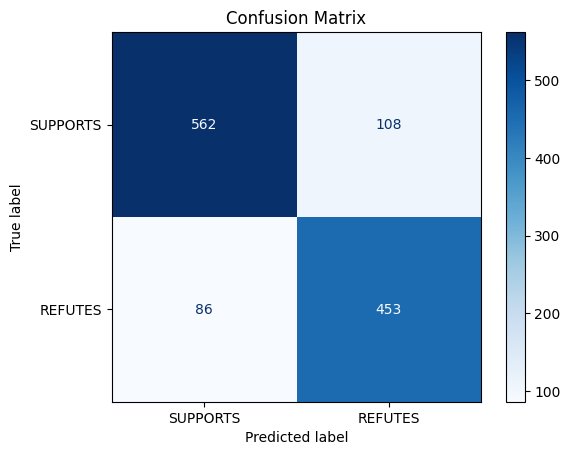

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = ["SUPPORTS", "REFUTES"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")

plt.savefig("confusion_matrix_vibert.png")
print("→ Đã lưu confusion matrix vào: confusion_matrix_vibert.png")

plt.show()

In [ ]:
import pandas as pd

df_test = test_dataset.to_pandas()

df_test["predicted_label"] = [id2label[i] for i in y_pred]

# Lưu ra file JSON
df_test.to_json("test_predictions.json", orient="records", force_ascii=False, indent=2)
print("\n→ Đã lưu kết quả test vào: test_predictions.json")


→ Đã lưu kết quả test vào: test_predictions.json
